In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure
from matplotlib import cm
import numpy as np

In [2]:
data_dir = 'ASL_Dataset'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(28),
    transforms.ToTensor()])

train_set = datasets.ImageFolder(data_dir + '/Train', transform=transform)
test_set = datasets.ImageFolder(data_dir + '/Test', transform=transform)

In [3]:
batch_size_train = 32
batch_size_test = 100
train = torch.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
test = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle=True)

In [4]:
def train_imshow():
    classes = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
               'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
              'U', 'V', 'W', 'X', 'Y', 'Z')
    dataiter = iter(train)
    images, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0)) 
        ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
    plt.show()

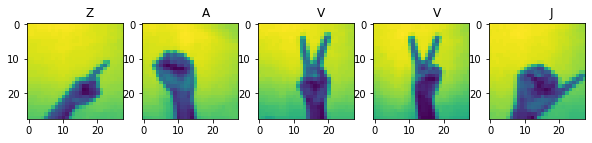

In [5]:
train_imshow()

In [6]:
class SimpleConvNetModel(nn.Module):
    def __init__(self, kernel_size1, stride1, kernel_size2, stride2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = kernel_size1, stride = stride1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = kernel_size2, stride = stride2)
        self.dense_layer = nn.Linear(320, 50)
        self.output_layer = nn.Linear(50, 26)

    def forward(self, x):
        
        z1 = self.conv1(x)
        
        z1_pooled = F.max_pool2d(z1, 2)

        a1 = F.relu(z1_pooled)
        
        z2 = self.conv2(a1)
        
        z2_pooled = F.max_pool2d(z2, 2) 
        
        a2 = F.relu(z2_pooled)
        
        a2 = a2.view(-1, 320) 
            
        z3_hidden = self.dense_layer(a2)

        a3 = F.relu(z3_hidden)

        a3_dropout = F.dropout(a3, training=self.training)

        output = self.output_layer(a3_dropout)
        return F.log_softmax(output, dim = 1)

In [7]:
net = SimpleConvNetModel(5, 1, 5, 1)

In [8]:
criterion = torch.nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

def train_net(n_epoch):
    losses = []
    for epoch in range(n_epoch):
        running_loss = 0.0
        for i, data in enumerate(train, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            losses.append(loss)
            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    plt.plot(losses, label='Training loss')
    plt.show()
    print('Finished Training')

[1,   100] loss: 0.1629198720
[1,   200] loss: 0.1628867809
[1,   300] loss: 0.1622057208
[1,   400] loss: 0.1583651263
[1,   500] loss: 0.1433964494
[1,   600] loss: 0.1239330519
[1,   700] loss: 0.1113613171
[1,   800] loss: 0.1005125965
[1,   900] loss: 0.0946800060
[1,  1000] loss: 0.0877753709
[1,  1100] loss: 0.0828980467
[1,  1200] loss: 0.0796118134
[1,  1300] loss: 0.0766890210
[1,  1400] loss: 0.0708826251
[1,  1500] loss: 0.0688064551
[1,  1600] loss: 0.0646674450
[1,  1700] loss: 0.0629855242
[1,  1800] loss: 0.0609917544
[1,  1900] loss: 0.0603741663
[1,  2000] loss: 0.0574690295
[1,  2100] loss: 0.0531752273
[1,  2200] loss: 0.0524251205
[1,  2300] loss: 0.0506404579
[1,  2400] loss: 0.0475197487
[1,  2500] loss: 0.0455937727
[1,  2600] loss: 0.0453137547
[1,  2700] loss: 0.0414910018
[1,  2800] loss: 0.0401764788
[1,  2900] loss: 0.0365377676
[1,  3000] loss: 0.0387949033
[1,  3100] loss: 0.0384093389
[1,  3200] loss: 0.0373170311
[1,  3300] loss: 0.0346443087
[1,  3400]

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

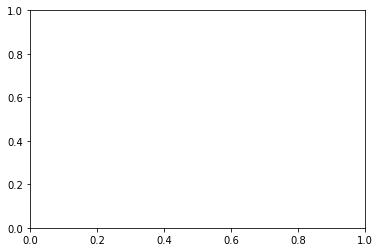

In [9]:
train_net(1)

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def conf_matrix(loader, model):
    predictions = []
    true_values = []

    for batch_idx, (data, target) in enumerate(loader):
        log_prob = model(data)
        prob = list(torch.exp(log_prob).detach().numpy())
        y = list(target.detach().numpy())
        for i in range(len(prob)):
            prob[i] = prob[i].tolist()
            prob[i] = (prob[i]).index(max(prob[i]))
            predictions.append(prob[i])
            true_values.append(y[i])



    cm = confusion_matrix(true_values, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

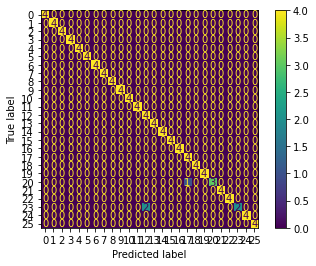

In [11]:
conf_matrix(test, net)

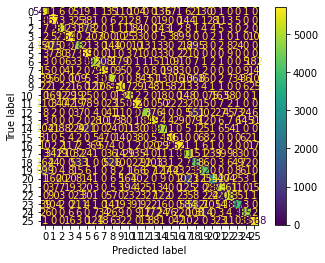

In [20]:
conf_matrix(train, net)

In [12]:
from sklearn.metrics import accuracy_score
def accuracy(loader, model):
    predictions = []
    true_values = []

    for batch_idx, (data, target) in enumerate(loader):
    
        log_prob = model(data)
       
        prob = list(torch.exp(log_prob).detach().numpy())
        y = list(target.detach().numpy())
        for i in range(len(prob)):
            prob[i] = prob[i].tolist()
            prob[i] = (prob[i]).index(max(prob[i]))
            predictions.append(prob[i])
            true_values.append(y[i])

    
    return accuracy_score(true_values, predictions)

In [17]:
print("test accuracy = ", accuracy(test, net))

test accuracy =  0.9230769230769231


In [19]:
print("train accuracy = ", accuracy(train, net))

train accuracy =  0.8521926288136916
